# Modelo de Budyco

# Motor del modelo

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

###############################################################################
# Discretisation and initialisation
# time
Nt = 21000                   # number of temporal steps
Dt = 20 * 60                 # time step is 20 minutes in seconds
tmax = Dt * Nt               # Tmax
t = np.arange(0, tmax, Dt)   # time array

# space
M = 180                            # spatial resolution
phi = np.deg2rad(np.linspace(-89.5, 89.5, M))  # the central angle of each grid
dphi = np.deg2rad(180 / M)         # the angle betwewen grid points
###############################################################################

###############################################################################
# Planet setup for basic case (all fields are latitude dependent, of size M)
eps = 0.6              # emissivity
h = 8300               # oceah height
hoc = 500              # surface ocean height
rho = 1.2              # air density
rhoc = 1028            # ocean density
C = 1000               # heat capacity of the air
Coc = 3900             # heat capacity for the ocean
sig = 5.67e-8          # SB constant     
S0 = 1368              # Solar constant
R = 6371 * 1000        # Earth Radious

K = (1.5 + 2.5 * np.cos(phi)) * 1e6          # diffusivity
dK = -2.5 * np.sin(phi) * 1e6                # diffusivity gradient
S = S0 * (0.5294 + 0.706 * np.cos(phi)**2)   # input irradiance
###############################################################################

###############################################################################
# auxiliary function that calculates global average of a given field
def average(var):
    return np.sum(np.cos(phi) * var) / np.sum(np.cos(phi))
###############################################################################

###############################################################################
# function to obtain the spatial derivatives given a field T(phi)
def gradients (T):
    # initialisation of variables to store the output
    gT = np.zeros(T.shape[0])      # the temperature first derivative (size M)
    ggT = np.zeros(T.shape[0])     # the temperature second derivative (size M)

    # first derivarive    
    gT[0] = (T[1] - T[0])/dphi    # Euler forward for left boundary
    gT[-1] = (T[-1] - T[-2])/dphi # Euler backward for right boundary
    gT[1:-1] = (T[2:] - T[:-2]) / (2 * dphi) # centered differences for inner grids (size M-2)

    # second derivative
    ggT[0] = (gT[1] - gT[0])/dphi    # Euler forward for left boundary
    ggT[-1] = (gT[-1] - gT[-2])/dphi # Euler backward for right boundary
    ggT[1:-1] = (T[2:] -2 * T[1:-1] + T[:-2]) / dphi**2 # centered differences for inner grids (size M-2)
    
    return gT, ggT
###############################################################################  
    
###############################################################################
# function that fills in T[M, Nt] according to the physical parameters and
# initial condition given in T[:,0]. 
# We use simple Euler forward in time.
def solve(T, feedback = 0, albedo_constant = 0):
    for i in range(1, Nt):
        gT, ggT = gradients(T[:,i-1]) # obtain gradients of T for this iteration
        albedo = get_albedo(T[:,i-1], feedback, albedo_constant) # obtain the albedo for this iteration
        
        # apply Euler forward in time to obtain T(t+Dt)
        T[:,i] = T[:,i-1] \
        + Dt * (1 - albedo[:]) * S[:] / (4 * C * rho * h) \
        - Dt * eps * sig * T[:,i-1]**4 / (C * rho * h) \
        + Dt / R**2 / np.cos(phi) * K  * np.cos(phi) * ggT \
        + Dt / R**2 / np.cos(phi) * dK * np.cos(phi) * gT \
        - Dt / R**2 / np.cos(phi) * K  * np.sin(phi) * gT
###############################################################################

###############################################################################
# function that solves the ec. iteratively to obtain T(t). It returns just the final (equilibrium) step
# We use simple Euler forward in time.
def balance_planet(T, feedback=0, albedo_constant=0):
    
    # first step: Euler forward
    gT, ggT = gradients(T) # obtain gradients of T for this iteration
    albedo = get_albedo(T, feedback, albedo_constant) # obtain the albedo for this iteration

    f = (1 - albedo) * S / (4 * C * rho * h) \
    - eps * sig * T**4 / (C * rho * h) \
    + 1 / R**2 / np.cos(phi) * K  * np.cos(phi) * ggT \
    + 1 / R**2 / np.cos(phi) * dK * np.cos(phi) * gT \
    - 1 / R**2 / np.cos(phi) * K  * np.sin(phi) * gT    

    Tnew = T + f * Dt
    Told = T
    T = Tnew
    
    # following steps: centered in time  (Ti-1 = Told, Ti = T, Ti+1 ) Tnew
    tol = 1e-5
    cont = 0
    while True:
        cont += 1
        gT, ggT = gradients(T) # obtain gradients of T for this iteration
        albedo = get_albedo(T, feedback, albedo_constant) # obtain the albedo for this iteration

        f = (1 - albedo) * S / (4 * C * rho * h) \
        - eps * sig * T**4 / (C * rho * h) \
        + 1 / R**2 / np.cos(phi) * K  * np.cos(phi) * ggT \
        + 1 / R**2 / np.cos(phi) * dK * np.cos(phi) * gT \
        - 1 / R**2 / np.cos(phi) * K  * np.sin(phi) * gT
        
        # apply Euler forward in time to obtain T(t+Dt)
        Tnew[:] = Told[:] + 1 * f[:] * Dt
        Told[:] = T[:] 
        T[:] = Tnew[:]

        if np.abs(np.max(2 * f * Dt)) < tol:
            print('Converged after %d iterations' % cont)
            return Tnew
        if cont > 40000:
            print('Equilibrium not reached after %d iterations' % 40000)
            print(Tnew)
#            raise Exception('exit')
            return np.nan
###############################################################################



###############################################################################
# function that calculates the albedo at each grid point as a function of T and phi
# this is where different feedbabcks can be programmed!
def get_albedo(T, feedback = 0, albedo_constant = 0):
    if feedback == 0: # simple constant albedo
        albedo = 0.6 - 0.4 * np.cos(phi)
    elif feedback == 1: # local calculation of albedo
        ice = 1 / (1 + np.exp(0.7*(T - 277.15)))
        albedo = ice * 0.75 + (1 - ice) * 0.25
    elif feedback == 2: # returns a given, constant albedo
        albedo = albedo_constant
    elif feedback == 3:  # global calculation of albedo
        Tg = average(T)
        T0 = 292.50565541823704
#        ice = 1 - np.cos(phi) - (Tg - 292.50565541823704) * 0.015
#        ice = np.where(ice>1, 1, ice)
#        ice = np.where(ice<0, 0, ice)
        A = 1 + np.log(T0/Tg)
        ice = (1 - np.cos(phi)) * A
        albedo = 0.4 * ice + 0.2
    else:
        print('Feedback type %d not implemented' % feedback)
        raise Exception('exit')   
    return albedo

def get_ice(T):
    Tg = average(T)
    ice = 1 - np.cos(phi) - (Tg - 292.50565541823704) * 0.015
    ice = np.where(ice>1, 1, ice)
    ice = np.where(ice<0, 0, ice)
    return ice
###############################################################################

# Evolución hacia el equilibrio

Converged after 18605 iterations


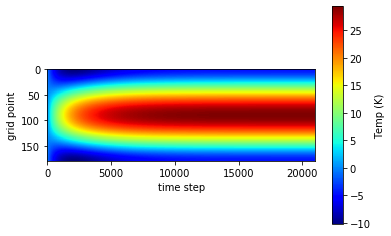

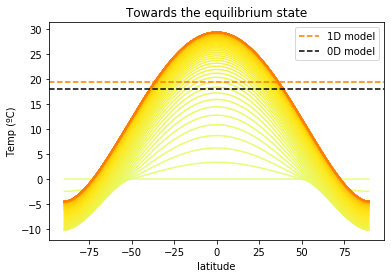

In [6]:

# run the simulation filling in the T matrix

T = np.zeros((M, Nt))              # temperature, (shape M x Nt)
T[:] = 273.15                    # we start the planet at homogeneous 0ºC
solve(T)



# apply the _fast approach for comparison
T_ = T[:,0]
T_ = balance_planet(T_)


# plot results

# as a colormap
fig, ax = plt.subplots()
im = ax.imshow(T - 273.15, cmap=cm.jet, aspect=40)
ax.set(xlabel='time step', ylabel='grid point')
cbar = fig.colorbar(im)
cbar.set_label('Temp (K)')
fig.savefig("T_evol1.pdf")

# as a series of coloured lines
fig, ax = plt.subplots()
color_palette = cm.Wistia(np.linspace(0, 1, len(range(1, Nt, 200))))
for this_color, step in zip(color_palette, range(1, Nt, 200)):
    ax.plot(np.rad2deg(phi), T[:,step]-273.15, c = this_color)

#ax.plot(np.rad2deg(phi), T_ - 273.15, c = 'tab:green')

plt.axhline(y = average(T[:,-1]) - 273.15, c = color_palette[-1], linestyle = 'dashed', label = '1D model')
S_mean = average(S)
albedo_mean = average(get_albedo(T[:,-1]))
T0D = np.power(S_mean*(1-albedo_mean)/4/eps/sig, 0.25)
plt.axhline(y = T0D - 273.15, c = 'black', linestyle = 'dashed', label = '0D model')

ax.set(xlabel='latitude', ylabel='Temp (ºC)')
ax.set_title('Towards the equilibrium state')
plt.legend()
fig.savefig("T_evol2.pdf")


Exp. 1 out of 14
Converged after 18242 iterations
Exp. 2 out of 14
Converged after 22178 iterations
Exp. 3 out of 14
Converged after 17332 iterations
Exp. 4 out of 14
Converged after 14512 iterations
Exp. 5 out of 14
Converged after 12577 iterations
Exp. 6 out of 14
Converged after 11124 iterations
Exp. 7 out of 14
Converged after 9974 iterations
Exp. 8 out of 14
Converged after 9033 iterations
Exp. 9 out of 14
Converged after 8243 iterations
Exp. 10 out of 14
Converged after 7569 iterations
Exp. 11 out of 14
Converged after 6987 iterations
Exp. 12 out of 14
Converged after 6478 iterations
Exp. 13 out of 14
Converged after 6031 iterations
Exp. 14 out of 14
Converged after 5634 iterations


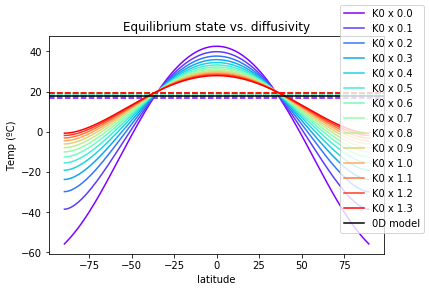

In [7]:

# set again the default setup (safety measure in case this block is run manually )
S = S0 * (0.5294 + 0.706 * np.cos(phi)**2)   # input irradiance
eps = 0.6
T = np.zeros((M))                # temperature, (shape M)
T[:] = 273.15                    # we start the planet at homogeneous 0ºC

Nexp = 14
k_factors = np.linspace(0, 1.3, Nexp)  # we go from 0 to 1.3 times the book case
T_K = np.zeros((M, Nexp)) # define an array to store the equilibrium states after each experiment

# loop in experiments. The result gets stored in the array T_K
for i, K0 in enumerate(k_factors):  #Note: i is the experiment number, K0 is the diffusivity amplitude 
    print('Exp. %s out of %s' % (i+1, Nexp))
    
    # modify the diffusivity to setup this 'world'
    K = (1.5 + 2.5 * np.cos(phi)) * 1e6 * K0
    dK = -2.5 * np.sin(phi) * 1e6 * K0
    
    # run this 'world' (after first step we start from a 'better' initial condition using the _fast approach)
    T_K[:,i] = balance_planet(T)
    T[:] = T_K[:,i]   # save the obtained profile as initial condition for next planet

# plot results
color_palette = cm.rainbow(np.linspace(0, 1, Nexp)) # palette
fig, ax = plt.subplots()

for this_color, i in zip(color_palette, range(Nexp)): # loop plotting 1 line per experiment with the given colour
    ax.plot(np.rad2deg(phi), T_K[:,i] - 273.15, label='K0 x %.1f' % (k_factors[i]), color = this_color) # plot profile
    plt.axhline(y = average(T_K[:,i]) - 273.15, color = this_color, linestyle = 'dashed')      # plot global average

# plot the result for the 0D model for comparison (only global average!)
S_mean = average(S)
albedo_mean = average(get_albedo(T_K[:,-1]))
T0D = np.power(S_mean*(1-albedo_mean)/4/eps/sig, 0.25)
plt.axhline(y=T0D - 273.15, color = 'black', label = '0D model')

# setup labels, axis, etc.
ax.set(xlabel='latitude', ylabel='Temp (ºC)')
ax.set_title('Equilibrium state vs. diffusivity')
fig.legend()
fig.savefig("Diffusivity.pdf")



Converged after 18626 iterations
Exp. 1 out of 5. eps = 0.57
Converged after 14632 iterations
Converged after 28057 iterations
Exp. 2 out of 5. eps = 0.58
Converged after 12198 iterations
Converged after 21445 iterations
Exp. 3 out of 5. eps = 0.60
Converged after 12088 iterations
Converged after 21970 iterations
Exp. 4 out of 5. eps = 0.61
Converged after 11953 iterations
Converged after 18180 iterations
Exp. 5 out of 5. eps = 0.63
Converged after 11822 iterations
Converged after 18195 iterations


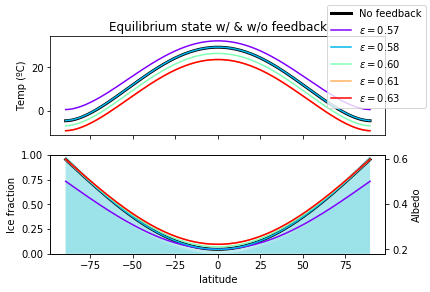

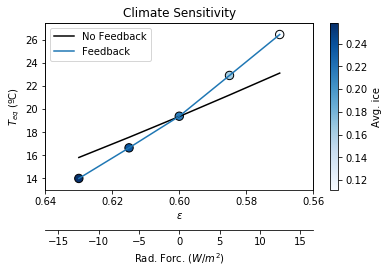

In [4]:

###############################################################################
# function that calculates the albedo at each grid point as a function of T and phi
# this is where different feedbabcks can be programmed!
def get_albedo(T, feedback = 0, albedo_constant = 0):
    if feedback == 0: # simple constant albedo
        albedo = 0.6 - 0.4 * np.cos(phi)
    elif feedback == 1: # local calculation of albedo
        ice = 1 / (1 + np.exp(0.7*(T - 277.15)))
        albedo = ice * 0.75 + (1 - ice) * 0.25
    elif feedback == 2: # returns a given, constant albedo
        albedo = albedo_constant
    elif feedback == 3:  # global calculation of albedo
        Tg = average(T)
        T0 = 292.50565541823704
        if Tg >= T0:
            A = 1 + 20 * np.log(T0/Tg)
            ice = (1 - np.cos(phi)) * A
        else:
            A = 1 - 3 * np.log(T0/Tg)
            ice = 1 - np.cos(phi) * A      
        albedo = 0.4 * ice + 0.2
    else:
        print('Feedback type %d not implemented' % feedback)
        raise Exception('exit')   
    return albedo

def get_ice(T):
    Tg = average(T)
    T0 = 292.50565541823704
    if Tg >= T0:
        A = 1 + 20 * np.log(T0/Tg)
        ice = (1 - np.cos(phi)) * A
    else:
        A = 1 - 3 * np.log(T0/Tg)
        ice = 1 - np.cos(phi) * A  
    return ice
###############################################################################




# set again the default setup (safety measure in case this block is run manually )
K = (1.5 + 2.5 * np.cos(phi)) * 1e6          # diffusivity
dK = -2.5 * np.sin(phi) * 1e6                # diffusivity gradient
S = S0 * (0.5294    + 0.706 * np.cos(phi)**2)   # input irradiance

#T = np.zeros(M)              # temperature, (shape M x Nt)
#T[:] = 273.15                    # we start the planet at homogeneous 0ºC

# setup list of perturbed climates
Nexp = 5
eps_min = 0.57
eps_max = 0.63
eps_list = np.linspace(eps_min, eps_max, Nexp)

# auxiliary function to compute RF from basic case (where Teq and eps are fixed)
def RF(eps):
    return -sig * np.power(292.50565541823704, 4) * (eps - 0.6) 

RF_list = RF(eps_list)

T_nf = np.zeros((M, Nexp))     # to store the temperature profiles without feedback
T_f = np.zeros((M, Nexp))      # to store the temperature profiles with feedback

Tg_nf = np.zeros(Nexp)  # to store the global average without feedback
Tg_f = np.zeros(Nexp)   # to store the global average with feedback
ice_f = np.zeros(Nexp)    # to store the amount of ice

# solve the basic case to obtain something to compare with
#solve(T)
#T_nf = balance_planet(T)
#albedo_nf = get_albedo(T_nf)

eps = 0.6
T_base = balance_planet(np.ones(M)*273)
albedo_base = get_albedo(T_base)
ice_base = get_ice(T_base)

T_nf[:,0] = T_base
T_f[:,0] = T_base

#loop in the experiments with different epsilons
for i in range(Nexp):
    eps = eps_list[i]
    print('Exp. %d out of %d. eps = %.2f' % (i+1, Nexp, eps))
 
    if i == 0:
        T_nf[:,i] = balance_planet(T_nf[:,i], feedback=0)
        T_f[:,i] = balance_planet(T_f[:,i], feedback=3)
    else:
        T_nf[:,i] = balance_planet(T_nf[:,i-1], feedback=0)
        T_f[:,i] = balance_planet(T_f[:,i-1], feedback=3)
    Tg_f[i] = average(T_f[:,i])
    Tg_nf[i] = average(T_nf[:,i])
    ice_f[i] = average(get_ice(T_f[:,i]))


# plot profiles for each experiment

# solution and plotting the result. Complex figure ahead! Please note:
# ax1 axes contain the temperature profiles
# ax2 axes contain the ice fraction profiles
# ax3 axes contain albedo profiles
# ax2 & ax3 axes are overlaid and share the x axis

color_palette = cm.rainbow(np.linspace(0, 1, Nexp))

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax3 = ax2.twinx()

ax1.set(ylabel='Temp (ºC)')
ax1.set_title('Equilibrium state w/ & w/o feedback')
ax2.set(xlabel = 'latitude', ylabel='Ice fraction')
ax2.set_ylim(0, 1)
ax3.set(xlabel='latitude', ylabel='Albedo')

ax1.plot(np.rad2deg(phi), T_base - 273.15, label='No feedback', c='black', linewidth=3) # draw basic T profile
ax3.plot(np.rad2deg(phi), albedo_base, c='black', linewidth=3) # draw basic albedo

for this_color, i in zip(color_palette, range(Nexp)):   
    ax1.plot(np.rad2deg(phi), T_f[:,i] - 273.15, label=r'$\epsilon = %.2f$' % eps_list[i], c = this_color)
    ax2.fill_between(np.rad2deg(phi), get_ice(T_f[:,i]), facecolor='tab:cyan', alpha=0.1)
    ax3.plot(np.rad2deg(phi), get_albedo(T_f[:,i], feedback=3), c=this_color)

fig.legend()
fig.savefig("Feedback1.pdf")



# plot climate sensityfivy figure
fig, ax1 = plt.subplots()
ax2 = ax1.twiny()

# Make some room at the bottom
fig.subplots_adjust(bottom=0.30)

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 40))

ax1.set_xlim(eps_max+0.01, eps_min-0.01)
ax2.set_xlim(RF(eps_max+0.01), RF(eps_min-0.01))

ax2.plot(RF_list, Tg_nf - 273.15 , color = 'black', label='No Feedback')
ax2.plot(RF_list, Tg_f - 273.15, label='Feedback')

im = ax1.scatter(eps_list, Tg_f - 273.15, c = ice_f, cmap=plt.cm.Blues, s=70, linewidths=1, edgecolors='black')
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Avg. ice')

ax1.set(xlabel='$\epsilon$', ylabel=r'$T_{eq}$ (ºC)')
ax2.set(xlabel='Rad. Forc. ($W/m^2$)')
ax1.set_title('Climate Sensitivity')

plt.legend(loc='upper left')
fig.savefig("Feedback2.pdf")
